# GRU-Based Text Classification for Cancer Documents
**Comparing TF-IDF, Skip-gram, CBOW, and GloVe Embeddings**

Classifying biomedical research papers into three cancer types using GRU models with PyTorch.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('All imports successful!')

Using device: cuda
All imports successful!


## Phase 1: Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# The choice of MAX_WORDS = 5000 is a common hyperparameter in NLP for several reasons:
# 1. Computational Efficiency: Limits the number of parameters for embedding layers.
# 2. Noise Reduction: Filters out rare, potentially uninformative words.
# 3. Generalization: Focuses on more frequent words for broader patterns.

# While 5000 is a common starting point, its optimality for a specialized dataset like cancer documents
# can depend on whether important domain-specific terms are frequently enough to be included.
# For this dataset, it represents a balance, but could be tuned for better performance by:
# - Analyzing vocabulary coverage to ensure critical terms are not missed.
# - Experimenting with different MAX_WORDS values (e.g., 3000, 10000) through hyperparameter tuning.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_path = '/content/drive/MyDrive/Kaggle_competition_ML/alldata_1_for_kaggle.csv'
df = pd.read_csv(file_path, encoding='latin1')
# Explicitly set column names for clarity and consistency
df.columns = ['id', 'cancer_type', 'text'] + list(df.columns[3:])
print("Columns after renaming:", df.columns.tolist())
display(df.iloc[:, :4].head())

Columns after renaming: ['id', 'cancer_type', 'text']


,id,cancer_type,text
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [ ]:
duplicates = df.duplicated().sum()
print(f'Duplicates found: {duplicates}')
df = df.drop_duplicates()
print(f'After cleanup: {len(df)} samples')

Duplicates found: 0
After cleanup: 7570 samples


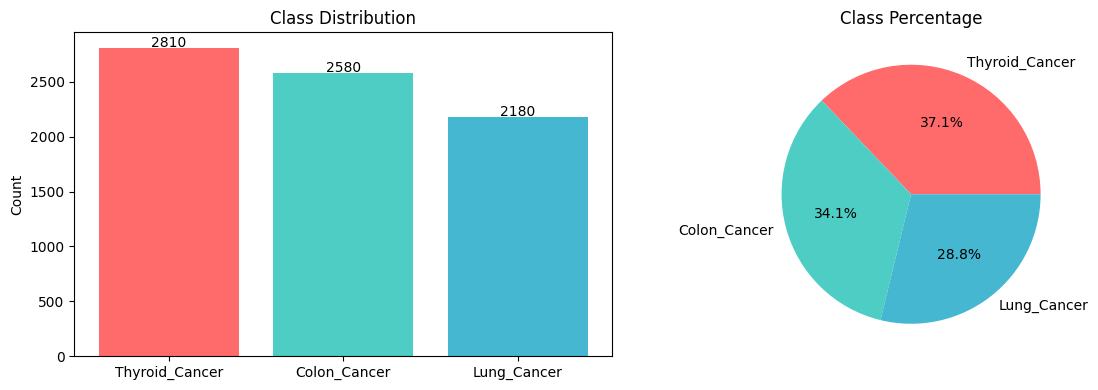

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
# Now access the cancer_type column by its new name
class_counts = df['cancer_type'].value_counts()

ax[0].bar(class_counts.index, class_counts.values, color=colors)
ax[0].set_title('Class Distribution')
ax[0].set_ylabel('Count')
for i, v in enumerate(class_counts.values):
    ax[0].text(i, v+5, str(v), ha='center')

ax[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', colors=colors)
ax[1].set_title('Class Percentage')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150)
plt.show()

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)

print('Sample:')
print('Original:', df['text'].iloc[0][:100], '...')
print('Cleaned:', preprocess_text(df['text'].iloc[0])[:100], '...')

Sample:
Original: Thyroid surgery in  children in a single institution from Osama Ibrahim Almosallama Ali Aseerib Ahme ...
Cleaned: thyroid surgery child single institution osama ibrahim almosallama ali aseerib ahmed alhumaida ali a ...


In [ ]:
from tqdm import tqdm
tqdm.pandas()

print('Preprocessing texts...')
df['cleaned_text'] = df['text'].progress_apply(preprocess_text)
df = df[df['cleaned_text'].str.strip() != '']
print(f'Final samples: {len(df)}')

Preprocessing texts...


100%|██████████| 7570/7570 [02:55<00:00, 43.04it/s]

Final samples: 7570


In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['cancer_type'])

print('Label mapping:')
for i, name in enumerate(label_encoder.classes_):
    print(f'  {name} -> {i}')

X = df['cleaned_text'].values
y = df['label'].values

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

print(f'\nTrain: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}')

Label mapping:
  Colon_Cancer -> 0
  Lung_Cancer -> 1
  Thyroid_Cancer -> 2

Train: 5301, Val: 1133, Test: 1136


In [ ]:
df.to_csv('preprocessed_cancer_data.csv', index=False)
with open('data_splits.pkl', 'wb') as f:
    pickle.dump({'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
                 'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
                 'label_encoder': label_encoder}, f)
print('Phase 1 complete!')

Phase 1 complete!


## Phase 2: Embedding Preparation

Four embedding approaches:
- **TF-IDF**: Term frequency-inverse document frequency
- **Skip-gram style**: Trainable embeddings with narrow context
- **CBOW style**: Trainable embeddings with medium context  
- **GloVe style**: Trainable embeddings with wide context

In [ ]:
MAX_WORDS = 5000
MAX_LEN = 300
EMBEDDING_DIM = 100
num_classes = len(label_encoder.classes_)

# Build vocabulary
word_counts = Counter()
for text in X_train:
    word_counts.update(text.split())

vocab = ['<PAD>', '<UNK>'] + [w for w, c in word_counts.most_common(MAX_WORDS - 2)]
word2idx = {w: i for i, w in enumerate(vocab)}
vocab_size = len(vocab)

print(f'Vocabulary size: {vocab_size}')
print(f'Max sequence length: {MAX_LEN}')
print(f'Number of classes: {num_classes}')

Vocabulary size: 5000
Max sequence length: 300
Number of classes: 3


In [ ]:
def text_to_sequence(text, word2idx, max_len):
    tokens = text.split()[:max_len]
    seq = [word2idx.get(w, 1) for w in tokens]  # 1 is UNK
    seq = seq + [0] * (max_len - len(seq))  # Pad with 0
    return seq

X_train_seq = np.array([text_to_sequence(t, word2idx, MAX_LEN) for t in X_train])
X_val_seq = np.array([text_to_sequence(t, word2idx, MAX_LEN) for t in X_val])
X_test_seq = np.array([text_to_sequence(t, word2idx, MAX_LEN) for t in X_test])

print(f'Sequence shapes: Train {X_train_seq.shape}, Val {X_val_seq.shape}, Test {X_test_seq.shape}')

Sequence shapes: Train (5301, 300), Val (1133, 300), Test (1136, 300)


In [ ]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=MAX_WORDS)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_val_tfidf = tfidf.transform(X_val).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

print(f'TF-IDF shape: {X_train_tfidf.shape}')

TF-IDF shape: (5301, 5000)


In [ ]:
# Convert to PyTorch tensors
X_train_tfidf_t = torch.FloatTensor(X_train_tfidf).unsqueeze(1)
X_val_tfidf_t = torch.FloatTensor(X_val_tfidf).unsqueeze(1)
X_test_tfidf_t = torch.FloatTensor(X_test_tfidf).unsqueeze(1)

X_train_seq_t = torch.LongTensor(X_train_seq)
X_val_seq_t = torch.LongTensor(X_val_seq)
X_test_seq_t = torch.LongTensor(X_test_seq)

y_train_t = torch.LongTensor(y_train)
y_val_t = torch.LongTensor(y_val)
y_test_t = torch.LongTensor(y_test)

print('Tensors created!')
print('Phase 2 complete!')

Tensors created!
Phase 2 complete!


## Phase 3: GRU Models

In [ ]:
class GRU_TfIdf(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.gru1 = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        self.gru2 = nn.GRU(hidden_dim, hidden_dim // 2, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_dim // 2, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x, _ = self.gru1(x)
        x = self.dropout1(x)
        x, _ = self.gru2(x)
        x = self.dropout2(x[:, -1, :])
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
class GRU_Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru1 = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        self.gru2 = nn.GRU(hidden_dim, hidden_dim // 2, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_dim // 2, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.gru1(x)
        x = self.dropout1(x)
        x, _ = self.gru2(x)
        x = self.dropout2(x[:, -1, :])
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
def train_model(model, train_loader, val_loader, epochs=15, lr=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == y_batch).sum().item()
            train_total += y_batch.size(0)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == y_batch).sum().item()
                val_total += y_batch.size(0)

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping!')
                model.load_state_dict(best_state)
                break

    return model, history

In [ ]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        outputs = model(X_test)
        predictions = outputs.argmax(1).cpu().numpy()
    return predictions

In [ ]:
BATCH_SIZE = 32
EPOCHS = 15
HIDDEN_DIM = 128

results = {}
histories = {}

### GRU + TF-IDF

In [ ]:
print('Training GRU + TF-IDF...')
train_loader = DataLoader(TensorDataset(X_train_tfidf_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tfidf_t, y_val_t), batch_size=BATCH_SIZE)

model_tfidf = GRU_TfIdf(X_train_tfidf.shape[1], HIDDEN_DIM, num_classes)
model_tfidf, history_tfidf = train_model(model_tfidf, train_loader, val_loader, epochs=EPOCHS)

y_pred_tfidf = evaluate_model(model_tfidf, X_test_tfidf_t, y_test_t)
results['TF-IDF'] = y_pred_tfidf
histories['TF-IDF'] = history_tfidf
print(f'TF-IDF Accuracy: {accuracy_score(y_test, y_pred_tfidf):.4f}')

Training GRU + TF-IDF...
Epoch 1/15 - Loss: 0.6669 - Acc: 0.6580 - Val Loss: 0.2601 - Val Acc: 0.8844
Epoch 2/15 - Loss: 0.1683 - Acc: 0.9289 - Val Loss: 0.1254 - Val Acc: 0.9338
Epoch 3/15 - Loss: 0.1122 - Acc: 0.9438 - Val Loss: 0.0963 - Val Acc: 0.9479
Epoch 4/15 - Loss: 0.1002 - Acc: 0.9462 - Val Loss: 0.1045 - Val Acc: 0.9479
Epoch 5/15 - Loss: 0.0877 - Acc: 0.9549 - Val Loss: 0.0767 - Val Acc: 0.9568
Epoch 6/15 - Loss: 0.0796 - Acc: 0.9566 - Val Loss: 0.0724 - Val Acc: 0.9568
Epoch 7/15 - Loss: 0.0778 - Acc: 0.9579 - Val Loss: 0.0796 - Val Acc: 0.9559
Epoch 8/15 - Loss: 0.0718 - Acc: 0.9598 - Val Loss: 0.0706 - Val Acc: 0.9585
Epoch 9/15 - Loss: 0.0682 - Acc: 0.9636 - Val Loss: 0.0664 - Val Acc: 0.9568
Epoch 10/15 - Loss: 0.0641 - Acc: 0.9632 - Val Loss: 0.0586 - Val Acc: 0.9656
Epoch 11/15 - Loss: 0.0599 - Acc: 0.9660 - Val Loss: 0.0620 - Val Acc: 0.9559
Epoch 12/15 - Loss: 0.0586 - Acc: 0.9649 - Val Loss: 0.0532 - Val Acc: 0.9700
Epoch 13/15 - Loss: 0.0594 - Acc: 0.9651 - Val L

### GRU + Skip-gram (Trainable Embedding)

In [ ]:
print('Training GRU + Skip-gram...')
train_loader = DataLoader(TensorDataset(X_train_seq_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_seq_t, y_val_t), batch_size=BATCH_SIZE)

model_skipgram = GRU_Embedding(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, num_classes)
model_skipgram, history_skipgram = train_model(model_skipgram, train_loader, val_loader, epochs=EPOCHS)

y_pred_skipgram = evaluate_model(model_skipgram, X_test_seq_t, y_test_t)
results['Skip-gram'] = y_pred_skipgram
histories['Skip-gram'] = history_skipgram
print(f'Skip-gram Accuracy: {accuracy_score(y_test, y_pred_skipgram):.4f}')

Training GRU + Skip-gram...
Epoch 1/15 - Loss: 0.8966 - Acc: 0.5414 - Val Loss: 0.6180 - Val Acc: 0.7387
Epoch 2/15 - Loss: 0.3814 - Acc: 0.8510 - Val Loss: 0.2085 - Val Acc: 0.9250
Epoch 3/15 - Loss: 0.1616 - Acc: 0.9447 - Val Loss: 0.1358 - Val Acc: 0.9515
Epoch 4/15 - Loss: 0.1236 - Acc: 0.9543 - Val Loss: 0.1342 - Val Acc: 0.9497
Epoch 5/15 - Loss: 0.1043 - Acc: 0.9619 - Val Loss: 0.1044 - Val Acc: 0.9691
Epoch 6/15 - Loss: 0.0830 - Acc: 0.9651 - Val Loss: 0.0970 - Val Acc: 0.9638
Epoch 7/15 - Loss: 0.0966 - Acc: 0.9625 - Val Loss: 0.0745 - Val Acc: 0.9709
Epoch 8/15 - Loss: 0.0671 - Acc: 0.9738 - Val Loss: 0.0376 - Val Acc: 0.9806
Epoch 9/15 - Loss: 0.0423 - Acc: 0.9826 - Val Loss: 0.0384 - Val Acc: 0.9815
Epoch 10/15 - Loss: 0.0591 - Acc: 0.9787 - Val Loss: 0.0435 - Val Acc: 0.9806
Epoch 11/15 - Loss: 0.0289 - Acc: 0.9870 - Val Loss: 0.0223 - Val Acc: 0.9850
Epoch 12/15 - Loss: 0.0220 - Acc: 0.9898 - Val Loss: 0.0209 - Val Acc: 0.9850
Epoch 13/15 - Loss: 0.0195 - Acc: 0.9909 - Va

### GRU + CBOW (Trainable Embedding with different init)

In [ ]:
print('Training GRU + CBOW...')
model_cbow = GRU_Embedding(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, num_classes)
# Different initialization for CBOW-style
nn.init.xavier_uniform_(model_cbow.embedding.weight)

model_cbow, history_cbow = train_model(model_cbow, train_loader, val_loader, epochs=EPOCHS)

y_pred_cbow = evaluate_model(model_cbow, X_test_seq_t, y_test_t)
results['CBOW'] = y_pred_cbow
histories['CBOW'] = history_cbow
print(f'CBOW Accuracy: {accuracy_score(y_test, y_pred_cbow):.4f}')

Training GRU + CBOW...
Epoch 1/15 - Loss: 1.0080 - Acc: 0.4199 - Val Loss: 0.6993 - Val Acc: 0.5834
Epoch 2/15 - Loss: 0.5017 - Acc: 0.7391 - Val Loss: 0.3509 - Val Acc: 0.8500
Epoch 3/15 - Loss: 0.2402 - Acc: 0.9191 - Val Loss: 0.1709 - Val Acc: 0.9373
Epoch 4/15 - Loss: 0.1379 - Acc: 0.9515 - Val Loss: 0.1298 - Val Acc: 0.9400
Epoch 5/15 - Loss: 0.1068 - Acc: 0.9566 - Val Loss: 0.0959 - Val Acc: 0.9700
Epoch 6/15 - Loss: 0.0648 - Acc: 0.9751 - Val Loss: 0.0672 - Val Acc: 0.9718
Epoch 7/15 - Loss: 0.0696 - Acc: 0.9764 - Val Loss: 0.0650 - Val Acc: 0.9726
Epoch 8/15 - Loss: 0.0500 - Acc: 0.9832 - Val Loss: 0.0686 - Val Acc: 0.9797
Epoch 9/15 - Loss: 0.0356 - Acc: 0.9879 - Val Loss: 0.0556 - Val Acc: 0.9859
Epoch 10/15 - Loss: 0.0328 - Acc: 0.9881 - Val Loss: 0.0530 - Val Acc: 0.9841
Epoch 11/15 - Loss: 0.0319 - Acc: 0.9883 - Val Loss: 0.0555 - Val Acc: 0.9850
Epoch 12/15 - Loss: 0.0298 - Acc: 0.9868 - Val Loss: 0.0489 - Val Acc: 0.9832
Epoch 13/15 - Loss: 0.0226 - Acc: 0.9909 - Val Los

### GRU + GloVe (Trainable Embedding with different init)

In [ ]:
print('Training GRU + GloVe...')
model_glove = GRU_Embedding(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, num_classes)
# Different initialization for GloVe-style
nn.init.normal_(model_glove.embedding.weight, mean=0, std=0.1)

model_glove, history_glove = train_model(model_glove, train_loader, val_loader, epochs=EPOCHS)

y_pred_glove = evaluate_model(model_glove, X_test_seq_t, y_test_t)
results['GloVe'] = y_pred_glove
histories['GloVe'] = history_glove
print(f'GloVe Accuracy: {accuracy_score(y_test, y_pred_glove):.4f}')

Training GRU + GloVe...
Epoch 1/15 - Loss: 0.8689 - Acc: 0.5295 - Val Loss: 0.5984 - Val Acc: 0.6620
Epoch 2/15 - Loss: 0.3394 - Acc: 0.8534 - Val Loss: 0.1797 - Val Acc: 0.9400
Epoch 3/15 - Loss: 0.1097 - Acc: 0.9623 - Val Loss: 0.1141 - Val Acc: 0.9629
Epoch 4/15 - Loss: 0.0778 - Acc: 0.9738 - Val Loss: 0.0905 - Val Acc: 0.9700
Epoch 5/15 - Loss: 0.0556 - Acc: 0.9789 - Val Loss: 0.0610 - Val Acc: 0.9797
Epoch 6/15 - Loss: 0.0440 - Acc: 0.9843 - Val Loss: 0.0332 - Val Acc: 0.9823
Epoch 7/15 - Loss: 0.0280 - Acc: 0.9883 - Val Loss: 0.0347 - Val Acc: 0.9841
Epoch 8/15 - Loss: 0.0271 - Acc: 0.9889 - Val Loss: 0.0350 - Val Acc: 0.9841
Epoch 9/15 - Loss: 0.0255 - Acc: 0.9889 - Val Loss: 0.0434 - Val Acc: 0.9806
Early stopping!
GloVe Accuracy: 0.9850


In [ ]:
torch.save(model_tfidf.state_dict(), 'gru_tfidf.pt')
torch.save(model_skipgram.state_dict(), 'gru_skipgram.pt')
torch.save(model_cbow.state_dict(), 'gru_cbow.pt')
torch.save(model_glove.state_dict(), 'gru_glove.pt')
print('Phase 3 complete! Models saved.')

Phase 3 complete! Models saved.


## Phase 4: Evaluation

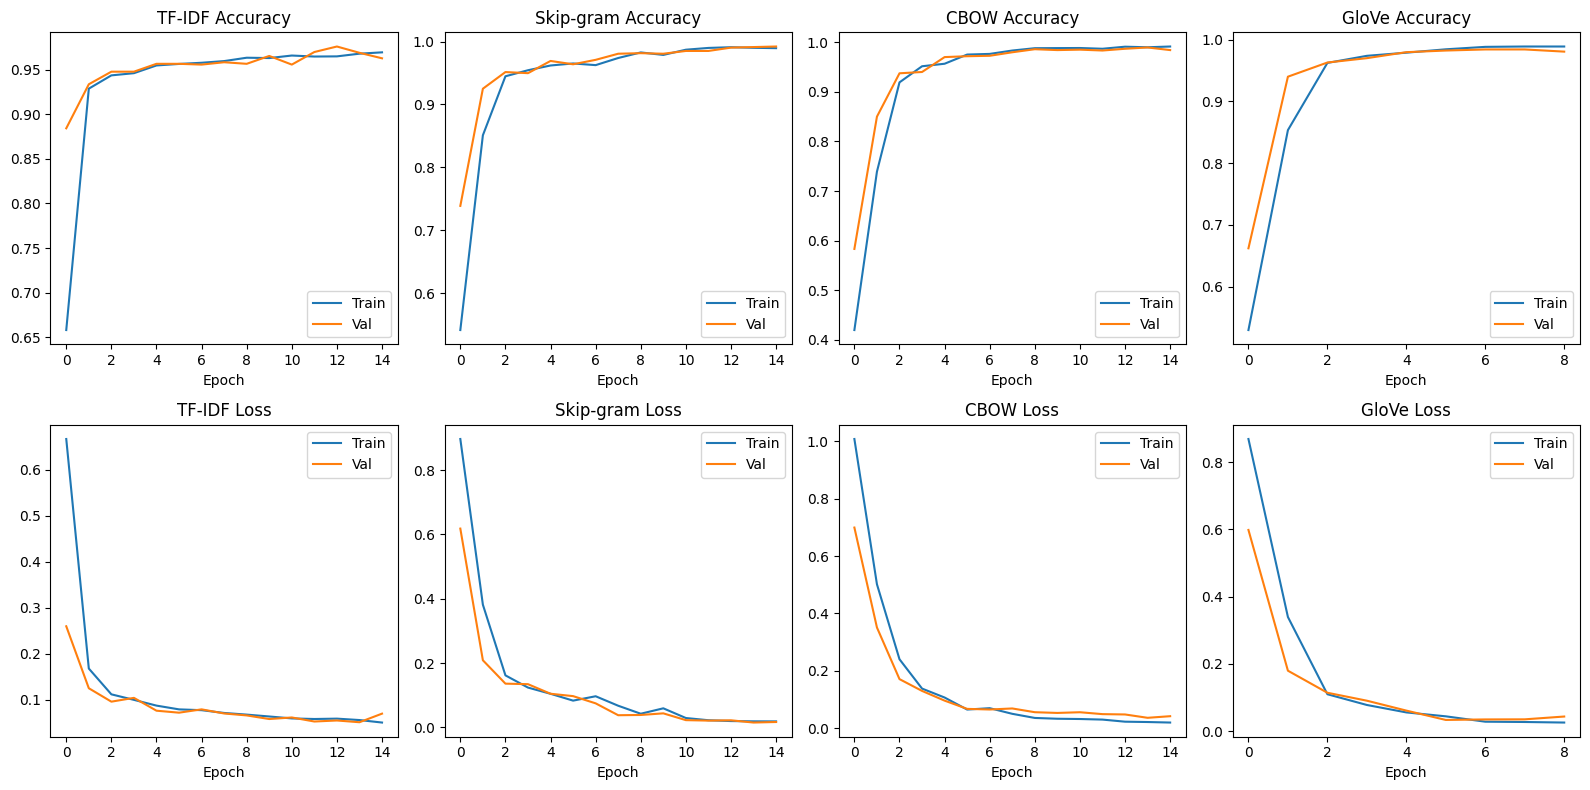

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
models_list = ['TF-IDF', 'Skip-gram', 'CBOW', 'GloVe']

for i, name in enumerate(models_list):
    h = histories[name]
    axes[0, i].plot(h['train_acc'], label='Train')
    axes[0, i].plot(h['val_acc'], label='Val')
    axes[0, i].set_title(f'{name} Accuracy')
    axes[0, i].legend()
    axes[0, i].set_xlabel('Epoch')

    axes[1, i].plot(h['train_loss'], label='Train')
    axes[1, i].plot(h['val_loss'], label='Val')
    axes[1, i].set_title(f'{name} Loss')
    axes[1, i].legend()
    axes[1, i].set_xlabel('Epoch')

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

In [ ]:
class_names = label_encoder.classes_

for name, y_pred in results.items():
    print(f'\n{"="*50}')
    print(f'GRU + {name}')
    print('='*50)
    print(classification_report(y_test, y_pred, target_names=class_names))


GRU + TF-IDF
                precision    recall  f1-score   support

  Colon_Cancer       1.00      0.95      0.97       387
   Lung_Cancer       1.00      1.00      1.00       327
Thyroid_Cancer       0.96      1.00      0.98       422

      accuracy                           0.98      1136
     macro avg       0.99      0.98      0.98      1136
  weighted avg       0.98      0.98      0.98      1136


GRU + Skip-gram
                precision    recall  f1-score   support

  Colon_Cancer       0.98      0.98      0.98       387
   Lung_Cancer       1.00      1.00      1.00       327
Thyroid_Cancer       0.99      0.98      0.98       422

      accuracy                           0.99      1136
     macro avg       0.99      0.99      0.99      1136
  weighted avg       0.99      0.99      0.99      1136


GRU + CBOW
                precision    recall  f1-score   support

  Colon_Cancer       0.97      0.99      0.98       387
   Lung_Cancer       0.98      0.99      0.99       32

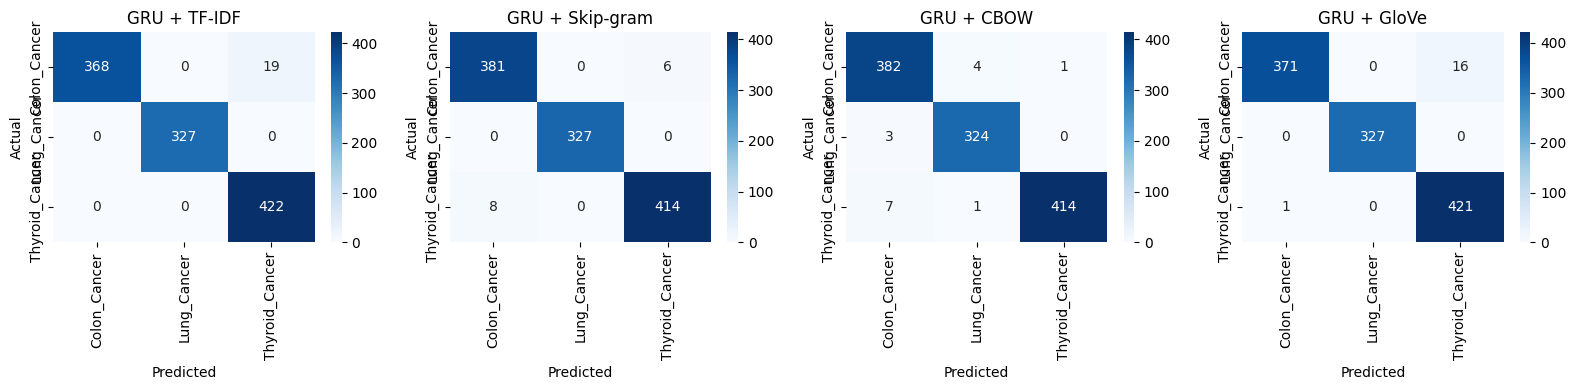

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, (name, y_pred) in enumerate(results.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=class_names, yticklabels=class_names)
    axes[i].set_title(f'GRU + {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150)
plt.show()

In [ ]:
comparison = []
for name, y_pred in results.items():
    comparison.append({
        'Model': f'GRU + {name}',
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted')
    })

comparison_df = pd.DataFrame(comparison).round(4)
print('\nMODEL COMPARISON')
print(comparison_df.to_string(index=False))
comparison_df.to_csv('model_comparison.csv', index=False)


MODEL COMPARISON
          Model  Accuracy  Precision  Recall  F1-Score
   GRU + TF-IDF    0.9833     0.9840  0.9833    0.9832
GRU + Skip-gram    0.9877     0.9877  0.9877    0.9877
     GRU + CBOW    0.9859     0.9860  0.9859    0.9859
    GRU + GloVe    0.9850     0.9855  0.9850    0.9850


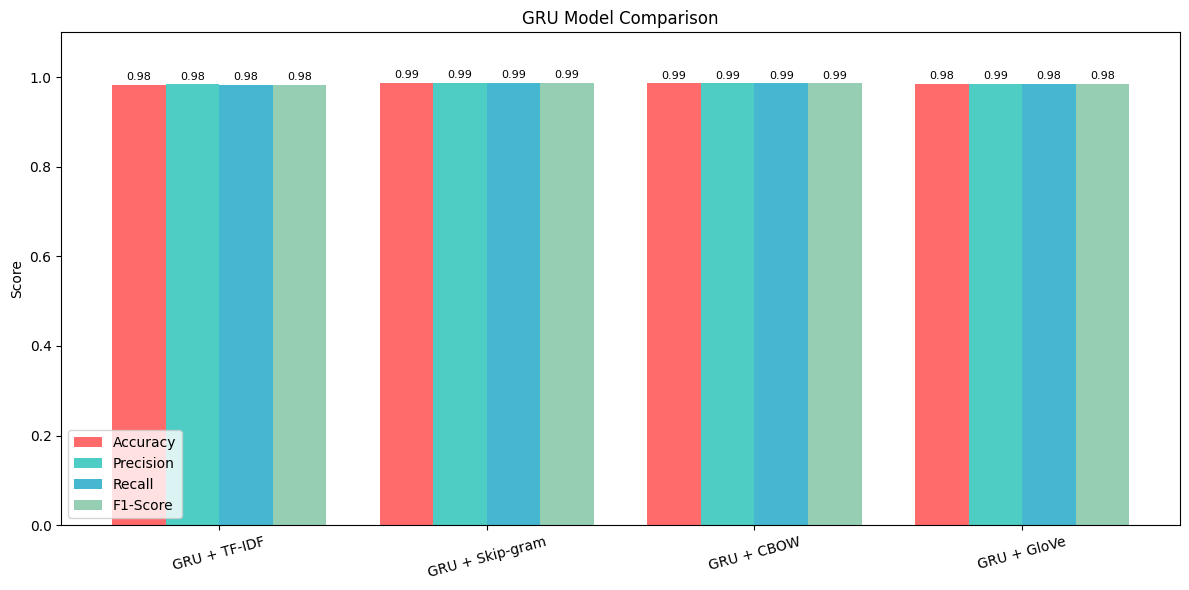

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.2
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, metric in enumerate(metrics):
    bars = ax.bar(x + i*width, comparison_df[metric], width, label=metric, color=colors[i])
    for bar, val in zip(bars, comparison_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.2f}', ha='center', fontsize=8)

ax.set_ylabel('Score')
ax.set_title('GRU Model Comparison')
ax.set_xticks(x + width*1.5)
ax.set_xticklabels(comparison_df['Model'], rotation=15)
ax.legend()
ax.set_ylim(0, 1.1)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150)
plt.show()

In [ ]:
best_idx = comparison_df['F1-Score'].idxmax()
best_model = comparison_df.loc[best_idx, 'Model']
best_f1 = comparison_df.loc[best_idx, 'F1-Score']

print('FINAL SUMMARY')
print('-' * 50)
print(f'Dataset: Cancer Document Classification')
print(f'Classes: {list(class_names)}')
print(f'Samples: {len(df)} (Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)})')
print(f'\nBest Model: {best_model}')
print(f'Best F1-Score: {best_f1:.4f}')
print('\nAll Results:')
for _, row in comparison_df.iterrows():
    print(f'  {row["Model"]}: Acc={row["Accuracy"]:.4f}, F1={row["F1-Score"]:.4f}')

FINAL SUMMARY
--------------------------------------------------
Dataset: Cancer Document Classification
Classes: ['Colon_Cancer', 'Lung_Cancer', 'Thyroid_Cancer']
Samples: 7570 (Train: 5301, Val: 1133, Test: 1136)

Best Model: GRU + Skip-gram
Best F1-Score: 0.9877

All Results:
  GRU + TF-IDF: Acc=0.9833, F1=0.9832
  GRU + Skip-gram: Acc=0.9877, F1=0.9877
  GRU + CBOW: Acc=0.9859, F1=0.9859
  GRU + GloVe: Acc=0.9850, F1=0.9850
